# Portfolio Backtesting

Portfolio backtesting is often conceived and perceived as a quest to find the best strategy - or at least a solid profitable one. When carried out thoroughly, this possibly long endeavor may entice the layman to confuse a fluke for a robust policy.

Two papers published back-to-back warn against the **perils of data snooping**, which is related to $p$-hacking. In both cases, researchers will torture the data until the sought result is found.

Fabozzi and de Prado (2018) and Arnott et al. (2016) stressed the importance to avoid **false positives** whereby strategies are found (often by cherrypicking) to outperform in one very particular setting but will likely to fail in live implementation.

Arnott et al. (2019a) also warn against the hazards of blindly investing in smart beta products related to academic factors. Another takeaway from their article is that **economic cycles** have a strong impact on factor returns: correlations change quickly and drawdowns can be magnified in times of major downturns.

Backtesting is more complicated than it seems and it is easy to make small mistakes that lead to apparently good portfolio policies. This chapter lays out a rigorous approach to this exercise, discusses a few caveats, and proposes a lengthy example.

## Setting the Protocol
We consider a dataset with 3 dimensions:
1. Time $t=1,\dots, T$
2. Assets $n=1,\dots,N$
3. Characteristics $k=1,\dots,K$

Some important characteristics:
- The price of asset $n$ at time $t$ which we will denote $p_{t,n}$
- The arithmetic return $r_{t,n}=p_{t,n}/p_{t-1,n}-1$
- Assuming each point in time $t$ has data available for all assets, this dataset has $I=T\times N$ rows.

The dataset is first split in two:
1. The **initial buffer period**: to train models and for the first portfolio composition.
  - can be fixed (usually 2 to 10 years) and expanding
  - Fixed: training sample rolling over time
  - Expanding: models built on all of the available data - can create problems since the first models are built on a much smaller dataset
  - Whether or not to include the full history of returns is advantageous? Unknown, some argue that this allows models to see many different **market conditions**, while others claim that old data can be outdated and possibly misleading.
2. The out-of-sample period

Henceforth, we choose the rolling period option for the training sample, as depicted in the following figure.

![FIGURE 12.1: Backtesting with rolling windows. The training set of the first period is simply the buffer period.](images/figure12-1.png)

Two crucial design choices are the **rebalancing frequency** and the **horizon** at which the label is computed. It can seem right to train on a 12-month forward label (which captures longer trends) and invest monthly or quarterly (so that they may not be equal). However, it seems odd to do the opposite and train on short-term movements (monthly) and invest at a long horizon.

These choices have a direct impact on how the backtest is carried out. If we note:
- $\Delta_h$ for the holding period between 2 rebalancing dates (in days or months)
- $\Delta_s$ for the size of the desired training sample (in days or months - not taking the number of assets into consideration)
- $\Delta_l$ for the hoziron at which the label is computed (in days or months).

Then the total length of the training sample should be $\Delta_s+\Delta_l$. Indeed, at any moment $t$, the training sample *should stop at* $t-\Delta_l$ so that the last point corresponds to a label that is calculated until time $t$, highlighted in the following figure 12.2 in the form of a *red danger zone*, naming from that any observation which has a time index $s$ inside the interval $(t-\Delta_l,t]$ will engender a forward looking bias. The feature generated by $s\in (t-\Delta_l,t]$ will cover the period $[s,s+\Delta_l]$ with $s+\Delta_l>t$, which requires unrealistic future knowledge.

![FIGURE 12.2: The subtleties in rolling training samples.](images/figure12-1.png)

## Turning Signals into Portfolio Weights

The predictive tools outlined in Chapters 5 to 11 are only meant to provide a *signal* that is expected to give some information on the future profitability of assets. There are many ways that this signal can be integrated in an investment decision (see Snow (2020) for ways to integrate ML tools into this task).

First and foremost, there are at least two steps in the portfolio construction process where the signal can be used. Note that relying on signals for both steps puts a lot of emphasis on the predictions and should only be considered when the level of confidence in the forecasts is high.

- Step 1: **Selection**. For long-only portfolios, it would make sense to take advantage of the signal to exclude those assets that are likely to underperform in the future.
  - A fixed-size portfolio with most favorable assets
  - This idea is often used in asset pricing literature: **sorted portfolios** (e.g., high average return for high quantiles)
  - An efficient way to test the relevance of the signal
  - If $Q$ portfolios $q=1,\dots,Q$ are formed according to the rankings of the assets with respect to the signal, the out-of-sample performance of portfolios are expected to be *monotonic* with $q$.
  - Mostly extreme portfolios suffice: if the difference between portfolio $\#1$ and $\#Q$ is substantial, then the signal is valuable.
  - Could make a dollar neutral strategy by shorting assets
- Step 2: **Weighting**.
  - Equally weighted portfolios are known to be hard to beat (see DeMiguel et al. (2009b)), especially compared to their cap-weighted alternative, as is shown in Plyakha et al. (2016).
  - More advanced techniques: equal risk contributions (Maillard et al., 2010), constrained minimum variance (Coqueret, 2015)
  - Both only rely on the covariance matrix of the assets and not on any proxy for the vector of expected returns.

For the sake of completeness, we explicitize a generalization of Coqueret (2015) which is a generic constrained quadratic program:
$$\underset{\textbf{w}}{\text{min}} \ \frac{\lambda}{2} \textbf{w}'\boldsymbol{\Sigma}\textbf{w}-\textbf{w}'\boldsymbol{\mu} , \quad \text{s.t.} \quad \begin{array}{ll} \textbf{w}'\textbf{1}=1, \\ (\textbf{w}-\textbf{w}_-)'\boldsymbol{\Lambda}(\textbf{w}-\textbf{w}_-) \le \delta_R,\\
\textbf{w}'\textbf{w} \le \delta_D,
\end{array}$$
where it's easy to recognize the usual **mean-variance optimization** in the left-hand side. We impose 3 constraints on the right-hand side:
1. Budget constraint: weights sum to 1.
2. Variation in weights penalization (compared to the current allocation $\textbf{w}_{-}$) via a diagonal matrix $\boldsymbol{\Lambda}$ that penalizes trading costs - reflects a usual case as **portfolio adjustments** from existing positions to reduce the orders and transaction costs. \
In this case above, the deviations from the current positions is $\textbf{w}-\textbf{w}_-$ and the term $(\textbf{w}-\textbf{w}_-)'\boldsymbol{\Lambda}(\textbf{w}-\textbf{w}_-)$ is an expression that characterizes the sum of squared deviations weighted by the diagonal coefficients $\Lambda_{n,n}$. This reduces costs induced by trading and liquidity with $\delta_R$.
3. The last constraint enforces **diversification** via the Herfindhal-Hirschmann index of the portfolio: smaller $\delta_D$ for a more diversified portfolio.
  
Recalling that there are N assets in the universe, the Lagrange form of the optimization problem is:
$$L(\textbf{w})= \frac{\lambda}{2} \textbf{w}'\boldsymbol{\Sigma}\textbf{w}-\textbf{w}'\boldsymbol{\mu}-\eta (\textbf{w}'\textbf{1}_N-1)+\kappa_R ( (\textbf{w}-\textbf{w}_-)'\boldsymbol{\Lambda}(\textbf{w}-\textbf{w}_-) - \delta_R)+\kappa_D(\textbf{w}'\textbf{w}-\delta_D)$$
and the first order condition
$$\frac{\partial}{\partial \textbf{w}}L(\textbf{w})= \lambda \boldsymbol{\Sigma}\textbf{w}-\boldsymbol{\mu}-\eta\textbf{1}_N+2\kappa_R \boldsymbol{\Lambda}(\textbf{w}-\textbf{w}_-)+2\kappa_D\textbf{w}=0$$
yields
$$\textbf{w}^*_\kappa=  (\lambda \boldsymbol{\Sigma}+2\kappa_R \boldsymbol{\Lambda} +2\kappa_D\textbf{I}_N)^{-1} \left(\boldsymbol{\mu} + \eta_{\lambda,\kappa_R,\kappa_D} \textbf{1}_N+2\kappa_R \boldsymbol{\Lambda}\textbf{w}_-\right)$$
with
$$\eta_{\lambda,\kappa_R,\kappa_D}=\frac{1- \textbf{1}_N'(\lambda\boldsymbol{\Sigma}+2\kappa_R \boldsymbol{\Lambda}+2\kappa_D\textbf{I}_N)^{-1}(\boldsymbol{\mu}+2\kappa_R\boldsymbol{\Lambda}\textbf{w}_-)}{\textbf{1}'_N(\lambda \boldsymbol{\Sigma}+2\kappa_R \boldsymbol{\Lambda}+2\kappa_D\textbf{I}_N)^{-1}\textbf{1}_N}.$$

This parameter ensures that the budget constraint is satisfied. The optimal weights depend on three tuning parameters: $\lambda, \kappa_R$ and $\kappa_D$:
- When $\lambda$ is large: the focus is set more on risk reduction than on profit maximization (which is often a good idea given that risk is easier to predict).
- When $\kappa_R$ is large, the importance of transaction costs is high and thus, in the limit when $\kappa_R \rightarrow \infty$, the optimal weights are equal to the old ones $\textbf{w}_-$ (for finite vaues of the other parameters).
- When $\kappa_D$ is large, the portfolio is more diversified and (all other things equal) when $\kappa_D \rightarrow \infty$, the weights are all equal (to $1/N$).
- When $\kappa_R=\kappa_D=0$, we recover the classical mean-variance weights which are a mix between the maximum Sharpe ratio portfolio proportional to $\boldsymbol{\Sigma}^{-1}\boldsymbol{\mu}$ and the minimum variance portfolio proportional to $\boldsymbol{\Sigma}^{-1}\boldsymbol{1}_N$.

This seemingly complex formula is in fact very flexible and tractable. It requires some tests and adjustments before finding realistic values for $\lambda, \kappa_R$ and $\kappa_D$. In Pedersen et al. (2020), the authors recommend a similar form, except that the covariance matrix is shrunk towards the diagonal matrix of sample variances and the expected returns are mix between a signal and an anchor portfolio. The authors argue that
their general formulation has links with robust optimization (see also Kim et al. (2014)), Bayesian inference (Lai et al. (2011)), matrix denoising via random matrix theory, and, naturally, shrinkage. In fact, shrunk expected returns have been around for quite some time (Jorion (1985), Kan and Zhou (2007) and Bodnar et al. (2013)) and simply seek to diversify and reduce estimation risk.

## Performance Metrics

The evaluation of performance is a key stage in a backtest. This section, while not exhaustive, is intended to cover the most important facets of portfolio assessment.

### Discussion

Portfolio returns are the ultimate yardstick during a backtest. One essential element in such an exercise is a **benchmark** because raw and absolute metrics don't mean much on their own.

A benchmark is also essential at the ML engine level - the MSE of the models in previous chapters revolves around 0.037, which is also the MSE of a constant prediction of 0 all the time. This means that the sophisticated algorithms don't really improve on a naive heuristic.
This benchmark is the one used in the out-of-sample R2 of Gu et al. (2020b).

In portfolio choice, the most elementary allocation is the uniform one, whereby each asset receives the same weight. This seemingly simplistic solution is in fact an incredible benchmark, one that is *hard to beat consistently*. Theoretically, uniform portfolios are optimal when uncertainty, ambiguity or estimation risk is high (Pflug et al. (2012), Maillet et al. (2015)) and empirically, it cannot be outperformed even at the factor level (Dichtl et al. (2020b)). 

Below, we will pick an **equally weighted** (EW) portfolio of all stocks as our benchmark.

### Pure Performance and Risk Indicators

We write $r^P=(r_t^P)_{1\leq t \leq T}$ and $r^B=(r_t^B)_{1\leq t \leq T}$ for the returns of the portfolio and those of the benchmark, respectively. When referring to some generic returns, we simply write $r_t$. There are many ways to analyze them and most of them rely on their distribution.

The simplest indicator is the average return:
$$\bar{r}_P=\mu_P=\mathbb{E}[r^P]\approx \frac{1}{T}\sum_{t=1}^T r_t^P, \quad \bar{r}_B=\mu_B=\mathbb{E}[r^B]\approx \frac{1}{T}\sum_{t=1}^T r_t^B$$
where, obviously, the portfolio is noteworthy if $\mathbb{E}[r^P]>\mathbb{E}[r^B]$. Note that we use the arithmetic average above but the geometric one is also an option, in which case:
$$\tilde{\mu}_P\approx \left(\prod_{t=1}^T(1+r^P_t) \right)^{1/T}-1 , \quad \tilde{\mu}_B \approx  \left(\prod_{t=1}^T(1+r^B_t) \right)^{1/T}-1$$
The benefit of an geometric average is that it takes the *compounding of returns* into account and hence compensates for volatility pumping. To see this, consider a very simple two-period model with returns $-r$ and $+r$, with arithmetic average as zero but the geometric average $\sqrt{1-r^2}-1$ negative.

The hit ratio measures the proportion of times when the position is in the right position (long - positive return, short - negative return) and evaluates the propensity to *make good guesses*. This can be computed at the asset level or at the portfolio level (also known as the *win rate*). In all cases, the computation can be performed on raw returns or on relative returns (relative to a benchmark). Hit ratio can be sometimes insuffcieint as many small gains can be offset by a few large losses.

Lastly, one important *precision*. In all examples of supervised learning tools in the book, we compared the hit ratios to 0.5. This is in fact problematic because if an investor is *bullish*, he or she may always bet on the upward moves. In this case, the hit ratio should be the percentage of time that *returns are positive*. Over the long run, this probability is above 0.5. In our sample, the ratio is 0.556, and this could be viewed as a benchmark to be surpassed.

Pure performance measures are almost always accompanied by **risk measures**. The second moment of returns is usually used to quantify the magnitude of fluctuations of the portfolio. A large variance implies sizable movements in returns, and hence in portfolio values. This is why the standard deviation of returns is called the **volatility** of the portfolio.
$$\sigma^2_P=\mathbb{V}[r^P]\approx \frac{1}{T-1}\sum_{t=1}^T (r_t^P-\mu_P)^2, \quad \sigma^2_B=\mathbb{V}[r^B]\approx \frac{1}{T-1}\sum_{t=1}^T (r_t^B-\mu_B)^2$$
In this case, the portfolio can be preferred if it's less risky compared to the benchmark, i.e., when $\sigma_P^2<\sigma_B^2$ and when average returns are equal (or comparable).

Higher order moments of returns are sometimes used (skewness and kurtosis), but are far less common. We refer to Harvey et al. (2010) for one method that takes them into account in the portfolio construction process.

For some people, the volatility is an incomplete measure of *risk*. It can be argued that it should be decomposed into '*good*' volatility (when prices go up) versus '*bad*' volatility when they go down. The *downward semi-variance* is computed as the variance taken over the negative returns: $$\sigma^2_-\approx \frac{1}{\text{card}(r_t<0)}\sum_{t=1}^T (r_t-\mu_P)^21_{\{r_t<0\}}$$

Other risk indicators rely on different aspects of the distribution of returns with a focus on *tails and extreme events*. The **Value-at-Risk** (VaR) is one such example. If $F_r$ is the empirical cdf of the returns, the VaR at a level of confidence $\alpha$ (often taken to be 95%) is $$\text{VaR}_\alpha(\textbf{r}_t)=F_r(1-\alpha)$$

It is equal to the realization of a bad scenario (of return) that is expected to happen $(1-\alpha)\%$ of the time on average. An even more conservative measure is the so-called **Conditional Value at Risk** (CVaR), also known as expected shortfall, which computes the average loss
of the worst $(1 − \alpha)\%$ scenarios. Its empirical evaluation is $$\text{CVaR}_\alpha(\textbf{r}_t)=\frac{1}{\text{Card}(r_t < \text{VaR}_\alpha(\text{r}_t))}\sum_{r_t < \text{VaR}_\alpha(\text{r}_t)}r_t$$

Going crescendo in the severity of risk measures, the ultimate evaluation of loss is the **maximum drawdown**, equal to the maximum loss suffered from the peak value of the strategy. If we write $P_t$ for the time-$t$ value of a portfolio, the drawdown is $$D_T^P=\max_{0\leq t\leq T} P_t-P_T$$ and the maximum drawdown is $$MD_T^P=\max_{0\leq s\leq T} \left(\max_{0\leq t\leq T} P_t-P_T, 0\right)$$
This quantity evalutes the greatest loss over the time frame $[0,T]$ and is thus the most conservative risk measure of all.

### Factor-based Evaluation

In the spirit of factor models, performance can also be assessed through the lens of *exposures*. The original formulation of a factor model is
$$r_{t,n}= \alpha_n+\sum_{k=1}^K\beta_{t,k,n}f_{t,k}+\epsilon_{t,n}$$
then the estimated $\hat{\alpha}_n$ is the performance that cannot be explained by the other factors.

When returns are *excess* returns and there is only one market factor, then this $\hat{\alpha}_n$ is called Jensen's alpha (Jensen, 1968), or simply referred to as *alpha*. The other estimate $\hat{\beta}_{t,M,n}$ ($M$ for market), is the market beta.

Because of the rise of factor investing, it has become customary to also report the alpha of more exhaustive regressions. Adding the size and value premium (as in Fama and French, 1993) and even momentum (Carhart, 1997) helps understand if a strategy generates value beyond that which can be obtained through the usual factors.

### Risk-adjusted Measures

Now, the tradeoff between the average return and the volatility is a cornerstone in modern finance, since Markowitz (1952). The simplest way to synthesize both metrics is via the **information ratio**:
$$IR(P,B)=\frac{\mu_{P-B}}{\sigma_{P-B}}$$
where the index $P-B$ implies that the mean and standard deviations are computed on the long-short portfolio with the returns $r_t^P-r_t^B$. The denominator $\sigma_{P-B}$ is sometimes called the **tracking error**.

The most widespread information ratio is the **Sharpe ratio** (Sharpe, 1966) for which the benchmark is some *riskless* asset. It is often customary to compare the Sharpe Ratios between two portfolios or strategies instead of directly computing the information ratio. Simple comparisons can benefit from statistical tests (see, e.g., Ledoit and Wolf, 2008).

More extreme risk measures can serve as denominator in risk-adjusted indicators. The *Managed Account Report* (MAR) ratio, is computed as $$MAR^P=\frac{\tilde{\mu}_P}{MD^P}$$
while the Treynor ratio is $$\text{Treynor}=\frac{\tilde{\mu}_P}{\hat{\beta}_M}$$
i.e. the (excess) return divided by the market beta (see Treynor, 1965). This definition was generalized to multifactor expositions by Hübner (2005) into the generalized Treynor ratio:
$$\text{GT}=\mu_P \frac{\sum_{k=1}^K \bar{f}_k}{\sum_{k=1}^K \hat{\beta}_k\bar{f}_k}$$
where the $\bar{f}_k$ are the sample average of the factors $f_{t,k}$. We refer to the original article for a detailed account of the analytical properties of this ratio.

### Transaction Costs and Turnover

Updating portfolio composition is not free. In all generality, the total cost of one rebalancing at time $t$ is proportional to $C_t=\sum_{n=1}^N | \Delta w_{t,n}|c_{t,n}$, where $\Delta w_{t,n}$ is the change in position for asset $n$ and $c_{t,n}$ is the corresponding fee. The fee is often hard to predict, thus it is customary to use a proxy that depends for instance on market capitalization (large stocks have more liquid shares and thus require smaller fees) or bid-ask spreads (smaller spreads -> smaller fees).

As a first order approximation, it is often useful to compute the average turnover: $$\text{Turnover}=\frac{1}{T-1}\sum_{t=2}^T\sum_{n=1}^N|w_{t,n}-w_{t-,n}|$$
where $w_{t,n}$ are the desired $t$-time weights in the portfolio and $w_{t-,n}$ are the weights just before the rebalancing. The positions of the first period (launching weights) are exluded from the computation by convention. Transaction costs can then be proxied as a multiple of turnover (times some average or median cost in the cross-section of firms). This is a first order estimate of realized costs that does not take into consideration the evolution of the scale of the portfolio. 

Once transaction costs (TCs) have been annualized, then can be deducted from average returns to yield a more realistic picture of profitability. In the same vein, the transaction cost-adjusted Sharpe Ratio of a portfolio $P$ is $$SR_{TC}=\frac{\mu_P-TC}{\sigma_P}$$

Transaction costs are often overlooked in academic articles but can have a *sizable impact* in real life trading to combine and offset positions and reduce overall fees.

## Common Errors and Issues

### Forward Looking Data

It is for instance easy to fall in the trap of the danger zone depicted in Figure 12.2. In this case, the labels used at time $t$ are computed with knowledge of what happens at times $t+1,t+2$, etc. It is worth triple checking every step in the code to make sure that strategies are ont built on prescient data.

### Backtest Overfitting

Backtest overfitting is a well-known issue and was formalized for instance in White (2000) and Romano and Wolf (2005). In portfolio choice, we refer to Bajgrowicz and Scaillet (2012) and Bailey and de Prado (2014) and the references therein.

At any given moment, a backtest depends on *only one* particular dataset. Often, the result of the first backtest will not be satisfactory - for many possible reasons. Hence, it is tempting to have another try, when altering some parameters that were probably not optimal. The second may be better, and a third with a new weighting scheme... Iteratively, the backtester can only end up with a strategy that performs well enough with just a matter of time and trials.

One consequence of backtest overfitting is that it is illusory to hope for the same Sharpe ratios in live trading as those obtained in the backtest. In Bailey and de Prado (2014), they even propose a statistical test for Sharpe ratios with the history of all tested strategies. The formula for deflated Sharpe Ratios is:
$$t = \phi\left((SR-SR^*)\sqrt{\frac{T-1}{1-\gamma_3SR+\frac{\gamma_4-1}{4}SR^2}} \right)$$
where $SR$ is the Sharpe Ratio obtained by the best strategy among all tested, and $$SR^*=\mathbb{E}[SR]+\sqrt{\mathbb{V}[SR]}\left((1-\gamma)\phi^{-1}\left(1-\frac{1}{N}\right)+\gamma \phi^{-1}\left(1-\frac{1}{Ne}\right)  \right)$$
is the theoretical average maximum SR. Moreover,
- $T$ is the number of trading dates;
- $\gamma_3$ and $\gamma_4$ are the *skewness* and *kurtosis* of the returns of the chosen (best) strategy;
- $\phi$ is the cdf of the standard normal distribution and $\gamma\approx 0.577$ is the Euler-Mascheroni constant;
- $N$ refers to the number of strategy trials.

If the $t$-statistic is below a certain threshold (e.g., 0.95), then the SR cannot be deemed significant: **the best strategy is not outstanding** compared to all of those that were tested. Most of the time, sadly, *that is the case*. In the above equation, the realized SR must be above the theoretical maximum $SR^*$ and the scaling factor must be sufficiently large to push the argument inside $\phi$ close enough to 2, so that $t$ surpasses 0.95.

In the scientific community, test overfitting is also known as $p$-hacking. This is common in financial economics or most fields that use statistical tests. There are several ways to cope with $p$-hacking:
1. Don't rely on $p$-values (Amrhein, et al., 2019)
2. Use detection tools (Elliott et al., 2019)
3. Or, finally, use advanced methods that process arrays of statistics (e.g., the Bayesianized versions of $p$-values to include some prior assessment from Harvey (2017), or other tests such as those proposed in Romano and Wolf (2005) and Simonsohn et al. (2014)).

The first option is wise, but the drawback is that the decision process is then left to another arbitrary yardstick.

### Simple Safeguards

As is mentioned at the beginning of the chapter, two common sense references for backtesting are Fabozzi and de Prado (2018) and Arnott et al. (2019b).

One additional comment pertains to the output of the backtest. One simple, intuitive and widespread metric is the transaction cost-adjusted Sharpe ratio defined above. In the backtest, let us call $SR_{TC}^B$ the corresponding value for the benchmark, which we like to define as the equally-weighted portfolio of all assets in the trading university (in our dataset, roughly 1,000 US equities). 

If the $SR_{TC}^P$ of the best strategy is above $2 \times SR_{TC}^B$, then there is probably a glitch somewhere in the backtest.

This criterion holds under two assumptions:
1. A sufficiently long enough out-of-sample period
2. Long-only portfolios

It is *unlikely* that any realistic strategy can outperform a solid benchmark by a very wide margin over the long term. Being able to improve the benchmark's annualized return by 150 basis point (1.5\%, with comparable volatility) is already a great achievement. Backtests that deliver returns more than 5% above those of the benchmark are dubious.

## Implication of Non-stationarity: Forecasting is hard

In this subsection we discuss
1. The reason that makes forecasting such a difficult task
2. An important theoretical result that sheds light on any discipline confronted with out-of-sample tests

Farmer et al. (2019) assess the predictive fit of linear models through time: they show that the fit is strongly *varying*: sometimes very well while sometimes not so much. There is no reason why this should not be the case for ML algorithms as well.

### General Comments

You may find throughout Chapters 5 to 11 that the performance of ML engines is underwhelming. These disappointing results are there on purpose and highlight the crucial truth that *most ML-based forecasts fail*. This is both true for enhanced and simpler techniques, which again underlines the need to *replicate results* to challenge their validity.

One reason for that is that datasets are *full of noise* and extracting the slightest amount of signal is a tough challenge (see Timmermann, 2018). One rationale for that is the ever *time-varying nature* of factor analysis in the equity space. Some factors can perform very well during one year and then poorly the next year and these reversals can be costly in the context of fully automated data-based allocation processes.

A major difference that ML has made is that it has found the *invariance* (Arjovsky et al., 2019) which is nonetheless the key to the great improvement both in CV and NLP.

In factor investing, there does *not* seem to be such invariance (Cornell, 2020). There is no factor and no (possibly nonlinear) combination of factors that can explain and accurately forecast returns over long periods of several decades. The academic literature has yet to find such a model; but even if it did, a simple arbitrage reasoning would logically invalidate its conclusions in future datasets.

### The No Free Lunch Theorem

We start by underlying that the no free lunch theorem in machine learning has nothing to do with the asset pricing condition with the same name (see, e.g., Delbaen and Schachermayer (1994), or, more recently, Cuchiero, Klein, and Teichmann (2016)). The original formulation was given by Wolpert (1992a) but we also recommend a look at the more recent reference Ho and Pepyne (2002). There are in fact several theorems and two of them can be found in Wolpert and Macready (1997).

The statement of the theorem is very abstract and requires some notational conventions. We assume that 
- Any training sample $S=(\{\textbf{x}_1,y_1\}, \dots, \{\textbf{x}_I,y_I\})$ is such that 
- There exists an oracle function $f$ that perfectly maps the features to the labels: $y_i=f(\textbf{x}_i)$. 
- The oracle function $f$ belongs to a very large set of functions $\mathcal{F}$. 
- In addition, we write $\mathcal{H}$ for the set of functions to which the forecaster will resort to approximate $f$. 
  - For instance, $\mathcal{H}$ can be the space of feed-forward neural networks, or the space of decision trees, or the unions of both.
  - Elements of $\mathcal{H}$ are written as $h$
  - $\mathbb{P}[h|S]$ stands for the (laregly unknown) distribution of $h$ knowing the sample $S$. Similarly, $\mathbb{P}[f|S]$ is the distribution of oracle functions knowing $S$.
- Finally, the features have a given law $\mathbb{P}[\textbf{x}]$.

Let us now consider two models, say $h_1$ and $h_2$. The statement of the theorem is usually formulated with respect to a classification task. Knowing $S$, the error when choosing $h_k$ induced by samples outside of the training sample $S$ can be quantified as:
$$E_k(S)= \int_{f,h}\int_{\textbf{x}\notin S} \underbrace{ (1-\delta(f(\textbf{x}),h_k(\textbf{x})))}_{\text{error term}} \underbrace{\mathbb{P}[f|S]\mathbb{P}[h|S]\mathbb{P}[\textbf{x}]}_{\text{distributional terms}}$$
where $\delta(\cdot, \cdot)$ is the delta Kronecker function:
$$\delta(x,y)=\begin{cases} 0 & \text{if } x\neq y \\ 1 & \text{if } x = y \end{cases}$$
One of the no free lunch theorems states that $E_1(S)=E_2(S)$, that is, that with the sole knowledge of $S$, there can be no superior algorithm, *on average*. In order to build a performing algorithm, one should have prior views on the *structure of the relationship* between $y$ and $\textbf{x}$ and integrate these views in the construction of the model. Unfortunately, this can also yield underperforming models if the views are incorrect.

## First Example: A Complete Backtest

We finally propose a full detailed example of one implementation of a ML-based strategy run on a careful backtest. What follows is a generalization of the content of Section 5.2.2. In the same spirit, we split the backtest in four parts:
1. The creation / initialization of variables;
2. The definition of the strategies in one main function;
3. The backtesting loop itself;
4. The performance indicators.

Accordingly, we start with initializations.

In [2]:
import pandas as pd
import numpy as np

data_ml = pd.read_pickle('./data/data_ml.pkl')

stock_days = data_ml[['date', 'stock_id']].groupby('stock_id').count()
stock_ids = stock_days[stock_days['date'] == max(stock_days['date'])].index
sub_data_ml = data_ml[data_ml['stock_id'].isin(stock_ids)]
returns = sub_data_ml.pivot(index = "date", columns = "stock_id", values = "R1M_Usd")

In [52]:
sep_oos = pd.to_datetime('2007-01-01')

ticks = data_ml['stock_id'].unique()
N = len(ticks)
t_oos = returns[returns.index > sep_oos].index.unique()
Tt = len(t_oos)
nb_port = 2
portf_weights = np.zeros(shape=(Tt, nb_port, np.max(ticks) + 1)) # slightly different
portf_returns = np.zeros(shape=(Tt, nb_port))

This first step is crucial which lays the groundwork for the core of the backtest. We consider only two strategies: one ML-based and the EW (1/N) benchmark. The ML-based weights are derived from XGBoost predictions with 80 trees, a learning rate of 0.3 and a maximum tree depth of 4. This makes the model complex but not exceedingly so. 

Once the predictions are obtained, the weighting scheme is simple: it is an EW portfolio over the *best half* of the stocks (those with above median prediction).

In the function below, all parameters are hard-coded. They can easily be passed in arguments next to the data inputs. 

One very important detail is that in contrast to the rest of the book, the label is the 12-month future return. The reason is discussed in Chapter 4.6 (to match the auto-correlation characteristics between the features and the label).

Also, to speed up the computations, we remove the bulk of the distribution of the labels and keep only the top 20% and bottom 20%, as is advised in Coqueret and Guida (2020). The filtering levels could also be passed as arguments.

In [53]:
from xgboost import XGBRegressor
def weights_xgb(train_data: pd.DataFrame, test_data: pd.DataFrame, features):
    train_features = train_data[features]
    train_label = train_data['R12M_Usd'] / np.exp(train_data['Vol1Y_Usd'])
    ind = (train_label < train_label.quantile(0.2)) | (train_label > train_label.quantile(0.8)) # Filter

    train_features = train_features[ind]
    train_label = train_label[ind]

    fit_xgb = XGBRegressor(n_estimators=80, max_depth=4, 
                           objective='reg:squarederror',
                           learning_rate=0.3)
    fit_xgb.fit(train_features, train_label)

    xgb_test = test_data[features]
    pred = fit_xgb.predict(xgb_test)
    w = pred > np.median(pred)
    w = w / np.sum(w) # equally weighted!
    w_names = test_data['stock_id']
    return w, w_names

Compared to the structure proposed in Section 6.4.6, the differences are that the label is not only based on **long-term returns**, but it also relies on a *volatility* component. Even though the denominator in the label is the exponential quantile of the volatility, it seems fair to say that it is inspired by the Sharpe ratio and that the model seeks to explain and forecast a *risk-adjusted return* instead of a raw return. A stock with very low volatility will have its return unchanged in the label, while a stock with very high volatility will see its return divided by a factor close to three $(\exp(1)=2.718)$.

This function is then embedded in the global weighting function which only wraps two schemes: the EW benchmark and the ML-based policy.

In [54]:
def portf_compo(train_data, test_data, features, j):
    if(j == 0):
        N = len(test_data['stock_id'].unique())
        w = np.ones(shape=(N, )) / N
        w_names = test_data['stock_id']
        return w, w_names
    if(j == 1):
        return weights_xgb(train_data, test_data, features)

Equipped with this function, we can turn to the main backtesting loop. Given the fact that we use a large-scale model, the computation time for the loop is large (possibly a few hours on a slow machine with CPU). Resorting to functional programming can speed up the loop (see exercise at the end of the chapter).

In [55]:
m_offset = 12
train_size = 5
features = data_ml.columns[2:95]

for t in range(len(t_oos) - 1):
    if((t + 1) % 12 == 0):
        print(t_oos[t])
    train_data = data_ml[(data_ml['date'] < t_oos[t] + pd.DateOffset(days=-m_offset * 30)) & \
                         (data_ml['date'] > t_oos[t] + pd.DateOffset(days=-m_offset * 30 - 365 * train_size))]
    test_data = data_ml[data_ml['date'] == t_oos[t]]
    realized_returns = test_data['R1M_Usd'] # 1M holding period

    for j in range(nb_port):
        tmp_weights, stocks = portf_compo(train_data, test_data, features, j)
        portf_weights[t, j, stocks] = tmp_weights
        portf_returns[t, j] = np.sum(tmp_weights * realized_returns)

2007-12-31 00:00:00
2008-12-31 00:00:00
2009-12-31 00:00:00
2010-12-31 00:00:00
2011-12-31 00:00:00
2012-12-31 00:00:00
2013-12-31 00:00:00
2014-12-31 00:00:00
2015-12-31 00:00:00
2016-12-31 00:00:00
2017-12-31 00:00:00


There are two important comments to be made on the above code. The parameters refer to the size of the training sample (5 years) and the length of the buffer period shown in Figure 12.2. **This buffer period is imperative** because the label is based on a long-term (12-month) return. This lag is compulsory to avoid any forward-looking bias in the backtest.

Below, we create a function that computes the turnover (variation in weights). It requires both the weight values as well as the returns of all assets because the weights just before a rebalancing depend on the weights assigned in the previous period, as well as on the returns of the assets that have altered these original weights during the holding period.

In [137]:
def turnover_func(weights, asset_returns, t_oos):
    turn = 0
    for t in range(1, len(t_oos)):
        # BUG for the original code HERE
        # should be `asset_returns`
        realized_returns = asset_returns[asset_returns.index == t_oos[t]].values
        prior_weights = weights[t - 1, ] * (1 + realized_returns)
        turn += np.sum(np.abs(weights[t, ] - prior_weights / np.sum(prior_weights)))
    return turn / (len(t_oos) - 1)

Once turnover is defined, we embed it into a function that computes several key indicators.

In [140]:
def perf_met(portf_returns, weights, asset_returns, t_oos):
    avg_ret = np.nanmean(portf_returns) # nan remove
    vol = np.nanstd(portf_returns, ddof=1)
    Sharpe_ratio = avg_ret / vol
    VaR_5 = np.quantile(portf_returns, 0.05)
    turn = turnover_func(weights, asset_returns, t_oos)
    met = [avg_ret, vol, Sharpe_ratio, VaR_5, turn]
    return met

Lastly, we build a function that loops on the various strategies.

In [139]:
def perf_met_multi(portf_returns, weights, asset_returns, t_oos, strat_name):
    J = weights.shape[1] # number of strategies
    met = [perf_met(portf_returns[:, j], weights[:, j, :], asset_returns, t_oos) for j in range(J)]
    met_result = pd.DataFrame(met, index=strat_name, columns = ['avg_ret', 'vol', 'Sharpe_ratio', 'VaR_5', 'turn'])
    return met_result

Given the weights and returns of the portfolios, it remains to compute the returns of the assets to plug them in the aggregate metrics function.

In [141]:
asset_returns = data_ml[['date', 'stock_id', 'R1M_Usd']].pivot(index = "date", columns = "stock_id", values = "R1M_Usd")
idx = list(set(range(np.max(asset_returns.columns) + 1)).difference(asset_returns.columns))
asset_returns[idx] = 0
asset_returns = asset_returns.sort_index(axis=1).fillna(0)

met = perf_met_multi(portf_returns, portf_weights,
                     asset_returns, t_oos, ["EW", "XGB_SR"])
met

,avg_ret,vol,Sharpe_ratio,VaR_5,turn
EW,0.009697,0.056429,0.171848,-0.077125,0.071451
XGB_SR,0.012589,0.063774,0.197406,-0.083359,0.568124


The ML-based strategy performs finally well! The gain is mostly obtained by the average return, while the volatility is higher than that of the benchmark. The net effect is that the Sharpe ratio is improved compared to the benchmark. The augmentation is not breathtaking, but (hence?) it seems reasonable. It is noteworthy to underline that turnover is substantially higher for the sophisticated strategy. Removing costs in the numerator (say, 0.005 times the turnover, as in Goto and Xu (2015), which is a conservative figure) only mildly reduces the superiority in Sharpe ratio of the ML-based strategy.

Finally, it is always tempting to plot the corresponding portfolio values and we display two related graphs as the following.

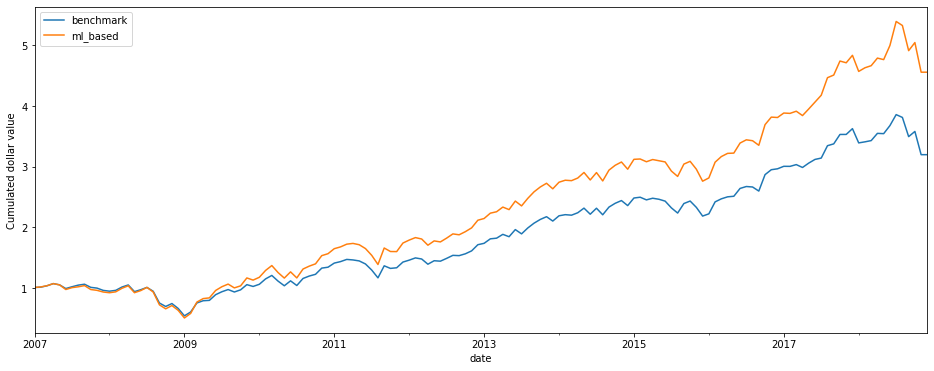

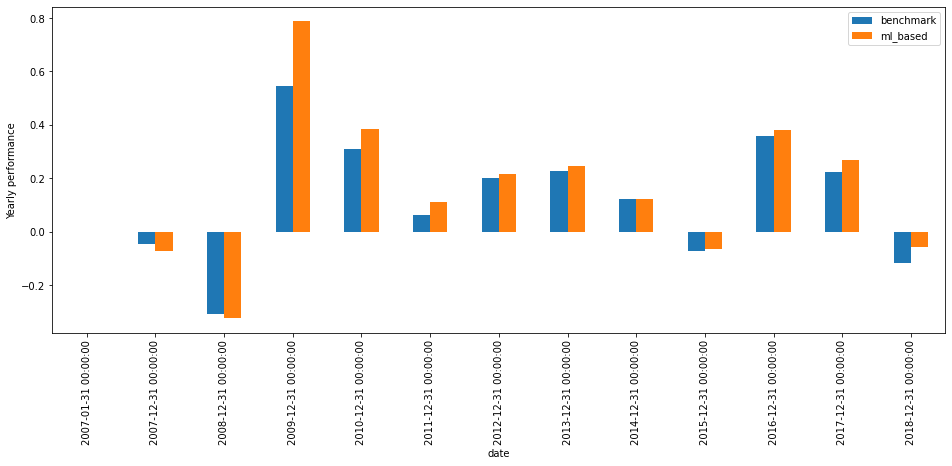

In [143]:
import matplotlib.pyplot as plt
g1 = pd.DataFrame([t_oos, np.cumprod(1 + portf_returns[:,0]), np.cumprod(1 + portf_returns[:,1])], index = ["date", "benchmark", "ml_based"]).T
g1.reset_index(inplace = True)
g1['date_month'] = pd.to_datetime(g1['date']).dt.month
g1.set_index('date', inplace = True)
g2 = g1[g1['date_month'] == 12]
g2 = pd.concat([g2, g1.iloc[[0]]])
g2.sort_index(inplace = True)
g1[["benchmark","ml_based"]].plot(figsize=[16, 6], ylabel='Cumulated dollar value')
g2[["benchmark","ml_based"]].pct_change(1).plot.bar(figsize=[16, 6],ylabel='Yearly performance')
plt.show()

Out of the 12 years of the backtest, the advanced strategy outperforms the benchmark during 10 years. It is less hurtful in two of the four years of aggregate losses (2015 and 2018). This is a satisfactory improvement because the EW benchmark is tough to beat!

## Second Example: Backtest Overfitting

To end this chapter, we quantify the concepts of Section 12.4.2. First, we build a function that is able to generate performance metrics for simple strategies that can be evaluated in batches. The strategies are pure factor bets and depend on three inputs: the chosen characteristic (e.g., market capitalization), a threshold level (quantile of the characteristic) and a direction (long position in the top or bottom of the distribution).

In [165]:
def strat(data: pd.DataFrame, feature: str, thresh, direction):
    data_tmp = data[[feature] + ['date', 'R1M_Usd']].reset_index().drop(columns='index')
    data_tmp['decision'] = direction * data_tmp[feature] > direction * thresh
    p_return = data_tmp.groupby('date').apply(
        lambda x: np.sum(x['decision'] / np.sum(x['decision']) * x['R1M_Usd'])
    )
    avg = np.nanmean(p_return)
    sd = np.nanstd(p_return, ddof=1)
    SR = avg / sd
    result = pd.DataFrame([avg, sd, SR], index=['avg', 'sd', 'SR']).T
    return result

Then, we test the function on a triplet of arguments. We pick the price-to-book (Pb) ratio. The position is positive and the threshold is 0.3, which means that the strategy buys the stocks that have a Pb value above the 0.3 quantile of the distribution.

In [166]:
strat(data_ml, "Pb", 0.3, 1)

,avg,sd,SR
0,0.010235,0.049553,0.206538


The output keeps three quantities that will be useful to compute the t-statistic (12.5). We must now generate these indicators for many strategies. We start by creating the grid of parameters.

In [170]:
import itertools
feature = ["Div_Yld", "Ebit_Bv", "Mkt_Cap_6M_Usd", "Mom_11M_Usd", "Pb", "Vol1Y_Usd"]
thresh = np.arange(0.2, 0.8, 0.1)
direction = [1, -1]
pars = list(itertools.product(feature, thresh, direction)) # Riccard Product
pars[:10]

[('Div_Yld', 0.2, 1),
 ('Div_Yld', 0.2, -1),
 ('Div_Yld', 0.30000000000000004, 1),
 ('Div_Yld', 0.30000000000000004, -1),
 ('Div_Yld', 0.4000000000000001, 1),
 ('Div_Yld', 0.4000000000000001, -1),
 ('Div_Yld', 0.5000000000000001, 1),
 ('Div_Yld', 0.5000000000000001, -1),
 ('Div_Yld', 0.6000000000000001, 1),
 ('Div_Yld', 0.6000000000000001, -1)]

In [172]:
pars_df = pd.DataFrame(pars, columns=['feature', 'thresh', 'direction'])

This makes 84 strategies in total. We can proceed to see how they fare. We plot the corresponding Sharpe ratios below. The top plot shows the strategies that invest in the bottoms of the distributions of characteristics while the bottom plot pertains to the portfolios that are long in the lower parts of these distributions.

In [198]:
grd = pd.DataFrame()
for idx, (feature, thresh, direction) in enumerate(pars):
    tmp_result = strat(data_ml, feature, thresh, direction)
    tmp_result['feature'] = feature
    tmp_result['thresh'] = thresh
    tmp_result['direction'] = direction
    grd = pd.concat([grd, tmp_result], ignore_index=True)
grd

,avg,sd,SR,feature,thresh,direction
0,0.011862,0.049947,0.237485,Div_Yld,0.2,1
1,0.016763,0.064708,0.259052,Div_Yld,0.2,-1
2,0.011307,0.048788,0.231760,Div_Yld,0.3,1
3,0.016360,0.063365,0.258194,Div_Yld,0.3,-1
4,0.011234,0.047990,0.234095,Div_Yld,0.4,1
...,...,...,...,...,...,...
79,0.009586,0.041122,0.233109,Vol1Y_Usd,0.6,-1
80,0.019774,0.081275,0.243292,Vol1Y_Usd,0.7,1
81,0.009932,0.043200,0.229917,Vol1Y_Usd,0.7,-1
82,0.023036,0.093037,0.247600,Vol1Y_Usd,0.8,1


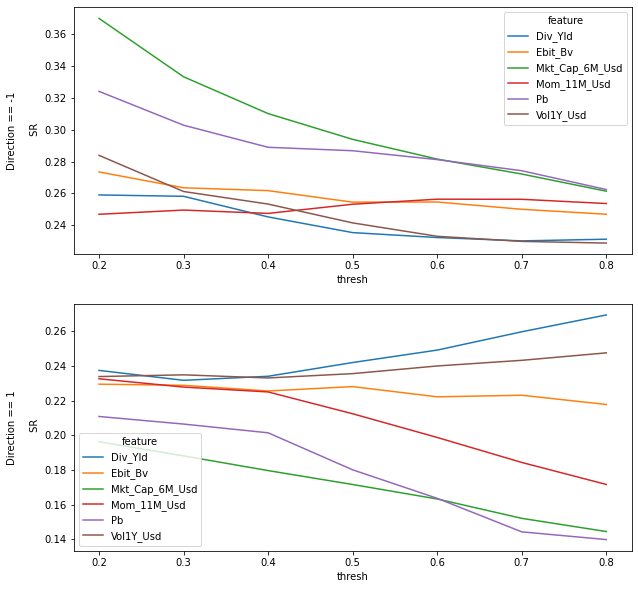

In [208]:
import matplotlib.pyplot as plt

plt.subplots(figsize=(10, 10))
ax1 = plt.subplot(211)
grd[grd['direction'] == -1].pivot(index='thresh', columns='feature', values='SR').plot(ax=ax1, ylabel='Direction == -1\n\n SR')
ax2 = plt.subplot(212)
grd[grd['direction'] == 1].pivot(index='thresh', columns='feature', values='SR').plot(ax=ax2, ylabel='Direction == 1\n\n SR')
plt.show()

The last step is to compute the statistic (12.5). We code it here:

In [222]:
from scipy.special import digamma
from scipy.stats import norm
def DSR(SR, Tt, M, g3, g4, SR_m, SR_v):
    gamma = -digamma(1) # Euler-Mascheroni Constant
    SR_star = SR_m + np.sqrt(SR_v) * ((1 - gamma) * norm.ppf(1 - 1 / M) + gamma * norm.ppf(1 - 1 / (M * np.exp(1))))
    num = (SR - SR_star) * np.sqrt(Tt - 1)
    den = np.sqrt(1 - g3 * SR + (g4 - 1) / 4 * np.square(SR))
    return norm.cdf(num / den)

All that remains to do is to evaluate the arguments of the function. The "best" strategy is the one on the top left corner of Figure 12.4 (above) and it is based on market capitalization.

In [224]:
import scipy.stats

M = grd.shape[0] # num of strategies tested
SR = np.max(grd['SR'])
SR_m = np.mean(grd['SR'])
SR_v = np.var(grd['SR'], ddof=1)
# Below, we compute the returns of the strategy by recycling the code of the strat() function

data_tmp = data_ml[['Mkt_Cap_6M_Usd', 'date', 'R1M_Usd']].reset_index().drop(columns='index')
data_tmp['decision'] = data_tmp['Mkt_Cap_6M_Usd'] < 0.2
p_return = data_tmp.groupby('date').apply(
    lambda x: np.sum(x['decision'] / np.sum(x['decision']) * x['R1M_Usd'])
)
g3 = scipy.stats.skew(p_return)
g4 = scipy.stats.kurtosis(p_return) + 3
Tt = p_return.shape[0]
DSR(SR, Tt, M, g3, g4, SR_m, SR_v)

0.665844894000408

The value 0.6658 is not high enough (to reach the 90% or 95% threshold) to make the strategy significantlly superior to the other ones that were considered in the batch of tests.

## Coding Exercises

1. Code the returns of the EW portfolio without loop.

In [226]:
rtn_EW = data_ml.groupby('date')['R1M_Usd'].mean()
rtn_EW.head()

date
2000-01-31    0.021098
2000-02-29    0.064126
2000-03-31    0.013529
2000-04-30   -0.007193
2000-05-31    0.017420
Name: R1M_Usd, dtype: float64

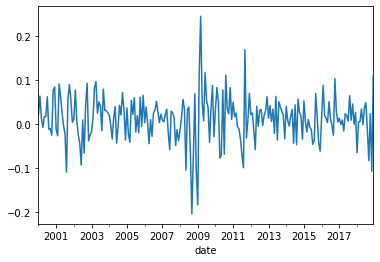

In [229]:
rtn_EW.plot()
plt.show()

2. Code the advanced weighting function defined in Equation (12.3).
3. Test it in a small backtest and check its sensitivity to the parameters.

$$\textbf{w}^*_\kappa=  (\lambda \boldsymbol{\Sigma}+2\kappa_R \boldsymbol{\Lambda} +2\kappa_D\textbf{I}_N)^{-1} \left(\boldsymbol{\mu} + \eta_{\lambda,\kappa_R,\kappa_D} \textbf{1}_N+2\kappa_R \boldsymbol{\Lambda}\textbf{w}_-\right)$$

$$\eta_{\lambda,\kappa_R,\kappa_D}=\frac{1- \textbf{1}_N'(\lambda\boldsymbol{\Sigma}+2\kappa_R \boldsymbol{\Lambda}+2\kappa_D\textbf{I}_N)^{-1}(\boldsymbol{\mu}+2\kappa_R\boldsymbol{\Lambda}\textbf{w}_-)}{\textbf{1}'_N(\lambda \boldsymbol{\Sigma}+2\kappa_R \boldsymbol{\Lambda}+2\kappa_D\textbf{I}_N)^{-1}\textbf{1}_N}$$

In [247]:
def advanced_weighting(Sigma: np.ndarray, Mu: np.ndarray, Lambda: np.ndarray, weights_org: np.ndarray, pen_lambda, kappa_r, kappa_d):

    idt = np.ones_like(Mu)
    den = pen_lambda * Sigma + 2 * kappa_r * Lambda + 2 * kappa_d * np.identity(Sigma.shape[0])
    den = np.linalg.inv(den)
    
    eta_num = 1 - np.linalg.multi_dot([idt.T, den, (Mu + 2 * kappa_r * np.dot(Lambda, weights_org))])
    eta_den = np.linalg.multi_dot([idt.T, den, idt])
    eta = eta_num / eta_den

    num = (Mu + eta * idt + 2 * kappa_r * np.dot(Lambda, weights_org))
    weights = np.dot(den, num)
    return weights

Now we will have a small numerical test for the function. We will use the return pivot table (defined in Chapter 1 and also in the first code trunk in this Chapter) as an example to calculate the $\boldsymbol{\Lambda}$ and $\boldsymbol{\mu}$. This may not be a good idea but again, we use this only for illustration purposes.

In [249]:
Sigma = returns.cov()
Mu = returns.mean(axis=0)
Lambda = np.diag(Sigma) # Use variance of returns as a proxy of the transaction cost
pen_lambda, kappa_r, kappa_d = 1, 1, 1
weights_org = np.ones_like(Mu) / Mu.shape[0] # Equal weights as original
weights_adv = advanced_weighting(Sigma, Mu, Lambda, weights_org, pen_lambda, kappa_r, kappa_d)
weights_adv[:10]

array([ 4.96942500e-03, -1.92729935e-03,  1.20691433e-03,  1.59937183e-03,
        1.89415245e-03, -2.11229191e-03, -1.28550341e-05, -1.29890094e-03,
        4.09919128e-03,  2.16529832e-03])

We will, following the official solution manual, examine 3 key indicators:
- **Diversification**, which we measure via the inverse of the sum of squared weights (inverse Hirschman-Herfindhal index);
- **Leverage**, which we assess via the absolute sum of negative weights;
- **In-sample Volatility**, which we compute as $\textbf{w}'\boldsymbol{\Sigma}\textbf{w}$.

In [277]:
def sensi(Sigma: np.ndarray, Mu: np.ndarray, Lambda: np.ndarray, weights_org: np.ndarray, pen_lambda, kappa_r, kappa_d):

    weights_adv = advanced_weighting(Sigma, Mu, Lambda, weights_org, pen_lambda, kappa_r, kappa_d)
    div = 1 / np.sum(np.square(weights_adv))
    lev = np.sum(np.abs(weights_adv[weights_adv < 0]))
    vol = np.linalg.multi_dot([weights_adv.T, Sigma, weights_adv])
    sensi_result = pd.DataFrame([div, lev, vol, pen_lambda, kappa_r, kappa_d], 
    index=['Diversification', 'Leverage', 'In-sample Volatility', 'lambda', 'kappa_r', 'kappa_d']).T
    return sensi_result

In [278]:
pen_lambdas = np.float_power(10, np.arange(-3, 2))
kappa_ds = 2 * pen_lambdas
kappa_rs = pen_lambdas.copy()
grids = list(itertools.product(pen_lambdas, kappa_ds, kappa_rs))

res = pd.DataFrame()
for pen_lambda, kappa_d, kappa_r in grids:
    res = pd.concat([res, sensi(Sigma, Mu, Lambda, weights_org, pen_lambda, kappa_d, kappa_r)], ignore_index=True)
res

,Diversification,Leverage,In-sample Volatility,lambda,kappa_r,kappa_d
0,0.000110,857.605287,6181.100438,0.001,0.002,0.001
1,0.006098,96.161500,256.433268,0.001,0.002,0.010
2,0.530817,9.297117,3.388459,0.001,0.002,0.100
3,49.044611,0.485776,0.041724,0.001,0.002,1.000
4,688.406825,0.000000,0.003474,0.001,0.002,10.000
...,...,...,...,...,...,...
120,0.000519,486.948561,0.005797,10.000,20.000,0.001
121,0.050919,48.752295,0.004424,10.000,20.000,0.010
122,3.947423,5.025991,0.001857,10.000,20.000,0.100
123,140.053115,0.426701,0.001141,10.000,20.000,1.000


We will try to plot some of them to see the sensitivity of weights to the parameters.

First, we will keep $\kappa_r$ and $\kappa_d$ fixed while $\lambda$ changing.

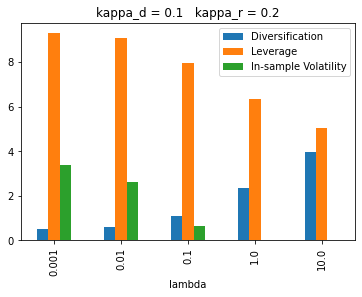

In [289]:
res_sub = res[(res['kappa_r'] == 0.2) & (res['kappa_d'] == 0.1)].drop(columns=['kappa_r', 'kappa_d'])
res_sub.set_index('lambda').plot.bar(figsize=(6, 4))
plt.title('kappa_d = 0.1   kappa_r = 0.2')
plt.show()

As $\lambda$ increases, the goal is set more on risk reduction, thus the diversification will reduce, and the leverage decreases, while volatility logically reduces.

Now, we will keep the $\lambda$ and $\kappa_d$ fixed.

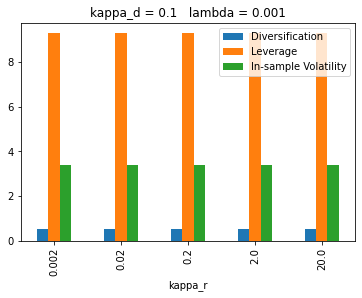

In [299]:
res_sub = res[(res['lambda'] == 0.001) & (res['kappa_d'] == 0.1)].drop(columns=['lambda', 'kappa_d'])
res_sub.set_index('kappa_r').plot.bar(figsize=(6, 4))
plt.title('kappa_d = 0.1   lambda = 0.001')
plt.show()

The effect of $\kappa_r$ seems minor in our case. Theoretically, when $\kappa_r$ is large, the importance of transaction costs is high.

Finally, we will explore the effect of $\kappa_d$.

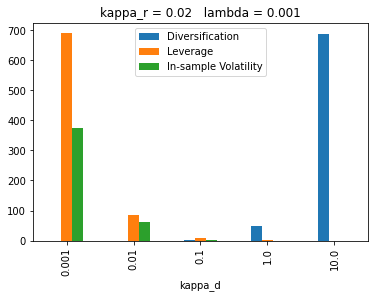

In [314]:
res_sub = res[(res['lambda'] == 0.01) & (res['kappa_r'] == 0.002)].drop(columns=['lambda', 'kappa_r'])
res_sub.set_index('kappa_d').plot.bar(figsize=(6, 4))
plt.title('kappa_r = 0.002   lambda = 0.01')
plt.show()

The effect of $\kappa_d$ seems to be very significant: the leverage and in-sample volatility reduces *drastically* with $\kappa_d$, while diversification increases drastically, corresponding to the theory.

## Takeaways

Portfolio backtesting: a quest to find the best (or at least a solidly profitable) strategy. **Data snooping** (or $p$-hacking) and **false positives** are major issues in portfolio backtesting.

- Protocol
  - Data splitting: the **initial buffer period** choices
    - Fixed: rolling training set
    - Expanding: balance between different market conditions and useless data
  - **Rebalancing frequency and horizon**: avoid the 'danger zone' and the forward looking bias
- Turning Signals into Portfolio Weights
  - **Selection**: select assets that are likely to perform well
    - **Sorted portfolios** according to factors, take 'extreme' portfolios or make dollar neural strategy
  - **Weighting**: equally weighted VS other techniques
    - Coqueret (2015): a constrained mean-variance optimization
- Performance Metrics
  - Discussion: set a **benchmark** case (probably with a EW portfolio)
  - Pure performance and risk indicators
    - **Average return** (arithmetic or geometric)
    - Accuracy or **win rate** (VS benchmark)
    - Precision (win rate on upward moves, VS benchmark)
    - Risk measures: **volatility**, downward semi-variance, (Conditional) Value-at-Risk, **maximum drawdown**
  - Factor-based Evaluation
    - Factor exposures
    - **Jensen's alpha** and market beta
  - Risk-adjusted Measures
    - Information ratio (and tracking error)
    - **Sharpe Ratio**
  - Transaction Costs and Turnover
    - **Turnover**
    - **Cost-adjusted Sharpe Ratio**
- Common Errors and Issues
  - Forward looking: carefully check!!
  - Backtest overfitting
    - Bailey and de Prado (2014): a statistical test for "outstanding" Sharpe ratios
    - Don't rely on $p$-values or some advanced techniques
  - Simple safeguards
    - Compare the cost-adjusted Sharpe ratio between the tested strategy and a benchmark with a sufficiently long enough out-of-sample period and long-only portfolios
- Implication of Non-stationarity: Forecasting is Hard
  - General Comments
    - Machine learning is no philosopher's stone or magic wand
    - Reasons: noise in datasets or (and) non-stationarity of factor analysis
    - ML techniques requires *invariance*, which factor investing does not seem to have
  - The no free lunch theorem
    - In order to build a performing algorithm, one must have prior views on the structure of the relationship between $y$ and $\textbf{x}$